In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.io.wavfile import write as wavwrite
from scipy.signal import chirp, tukey, fftconvolve, correlate
import scipy.signal as signal
import matplotlib.pyplot as plt
import os

import numpy as np
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt

def generate_exponential_sine_sweep(fs=48000, amplitude=0.5, duration=16, silenceAtStart=1, silenceAtEnd=1, sweeprange=[20, 20000], bit_depth=16):
    """
    Generate an exponential sine sweep and its inverse filter, and save them as WAV files with the specified bit depth.
    
    Parameters:
    - fs: Sampling rate (Hz)
    - amplitude: Amplitude of the sine sweep
    - duration: Duration of the sine sweep (seconds)
    - silenceAtStart: Silence duration at the start (seconds)
    - silenceAtEnd: Silence duration at the end (seconds)
    - sweeprange: Start and end frequencies of the sweep (Hz)
    - bit_depth: Bit depth of the output WAV files (16, 24, or 32)
    """
    # Define the frequency range for the sweep
    f1 = max(sweeprange[0], 1)  # start of sweep in Hz
    f2 = sweeprange[1] if sweeprange[1] != 0 else int(fs / 2)  # end of sweep in Hz
    
    w1 = 2 * np.pi * f1 / fs  # start of sweep in rad/sample
    w2 = 2 * np.pi * f2 / fs  # end of sweep in rad/sample
    
    numSamples = duration * fs
    taxis = np.arange(0, numSamples) / numSamples

    # Generate the exponential sine sweep
    lw = np.log(w2 / w1)
    sinsweep = amplitude * np.sin(w1 * numSamples / lw * (np.exp(taxis * lw) - 1))
    
    # Find the last zero crossing to avoid the need for fadeout
    k = np.flipud(sinsweep)
    error = 1
    counter = 0
    max_iterations = numSamples  # to avoid infinite loop

    while error > 0.001 and counter < max_iterations:
        error = np.abs(k[counter])
        counter += 1

    k = k[counter:]
    sinsweep_hat = np.flipud(k)
    sinsweep = np.zeros(shape=(numSamples,))
    sinsweep[:sinsweep_hat.shape[0]] = sinsweep_hat

    # Compute the inverse filter
    envelope = (w2 / w1) ** (-taxis)
    invfilter = np.flipud(sinsweep) * envelope
    scaling = np.pi * numSamples * (w1 / w2 - 1) / (2 * (w2 - w1) * np.log(w1 / w2)) * (w2 - w1) / np.pi
    invfilter = invfilter / amplitude ** 2 / scaling

    # Apply a Tukey window to taper the sine sweep
    #taperStart = signal.tukey(numSamples, 0.1)  # Adjust alpha parameter for tapering
    #sinsweep *= taperStart

    # Add silence at the start and end
    #zerostart = np.zeros(shape=(silenceAtStart * fs,))
    #zeroend = np.zeros(shape=(silenceAtEnd * fs,))
    #sinsweep = np.concatenate((zerostart, sinsweep, zeroend))

    # Normalize and convert to the specified bit depth

    sinsweep = np.int16(sinsweep / np.max(np.abs(sinsweep)) * 32767)
    invfilter = np.int16(invfilter / np.max(np.abs(invfilter)) * 32767)

    print(f'Sine sweep and inverse filter generated and saved as {bit_depth}-bit WAV files.')
    return sinsweep, invfilter, fs

def align_signals(recorded_sweep, reference_signal):
    correlation = correlate(recorded_sweep, reference_signal, mode='full')
    start_index = np.argmax(np.abs(correlation)) - len(reference_signal) + 1
    recorded_sweep = recorded_sweep[max(0, start_index):start_index+len(reference_signal)]
    min_length = min(len(recorded_sweep), len(reference_signal))
    return recorded_sweep[:min_length], reference_signal[:min_length]

def compute_rir(recorded_sweep, inverse_filter, fs, keep_duration=10):
    rir = fftconvolve(recorded_sweep, inverse_filter, mode='full')
    peak_index = np.argmax(np.abs(rir))
    rir = rir[peak_index:peak_index+int(fs * keep_duration)]
    fade_out = np.linspace(1, 0, int(0.1 * fs))**2
    rir[-len(fade_out):] *= fade_out
    return rir / np.max(np.abs(rir))

def plot_signal(signal, fs, title, xlabel='Time (s)', ylabel='Amplitude'):
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(signal)) / fs, signal)
    plt.title(title), plt.xlabel(xlabel), plt.ylabel(ylabel), plt.grid(True)
    plt.show()

def plot_rir_and_spectrum(rir, fs):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(rir)) / fs, rir)
    plt.title('Room Impulse Response'), plt.xlabel('Time (s)'), plt.ylabel('Amplitude'), plt.grid(True)
    plt.subplot(2, 1, 2)
    freq_response = np.abs(np.fft.rfft(rir))
    freq_axis = np.fft.rfftfreq(len(rir), d=1/fs)
    plt.semilogx(freq_axis, 20 * np.log10(freq_response))
    plt.title('Frequency Response of RIR'), plt.xlabel('Frequency (Hz)'), plt.ylabel('Magnitude (dB)')
    plt.xlim(20, fs/2), plt.ylim(-60, 0), plt.grid(True)
    plt.tight_layout(), plt.show()


Sine sweep and inverse filter generated and saved as 16-bit WAV files.


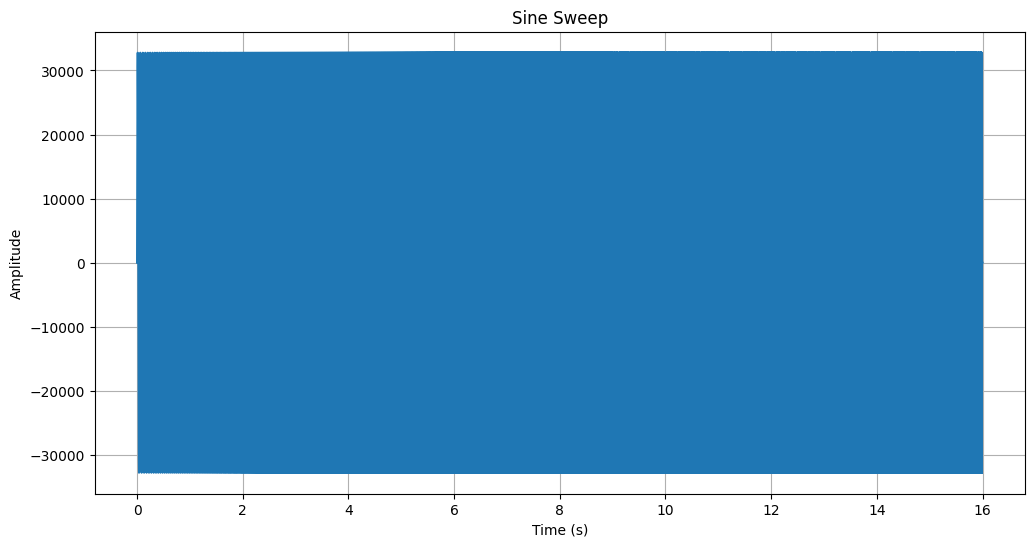

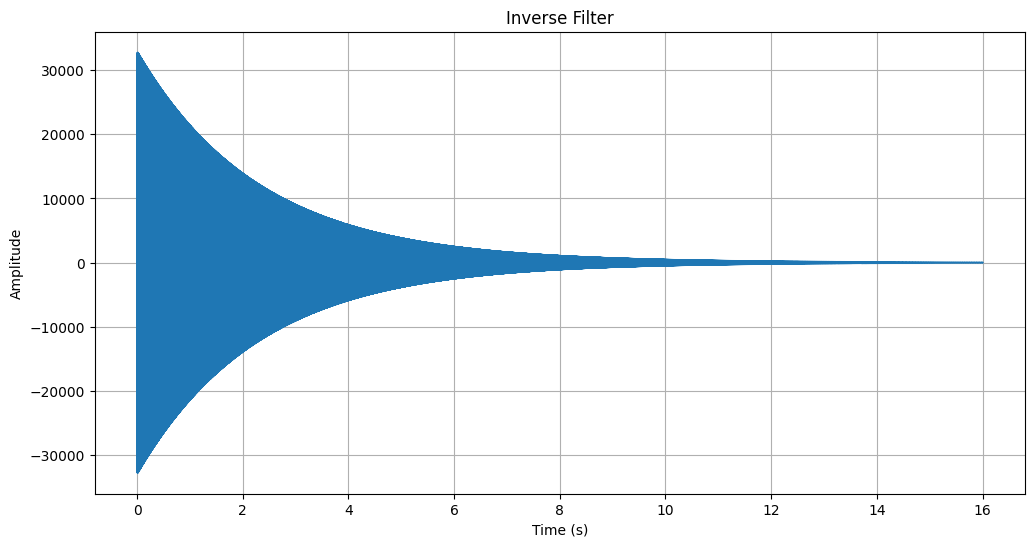

In [2]:
# Main execution
sweep, inverse_filter, fs = generate_exponential_sine_sweep()

# Save sweep and inverse filter
wavfile.write('sine_sweep_16bit_full.wav', fs, sweep)
wavfile.write('inverse_filter_16bit_full.wav', fs, inverse_filter)
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')
wavfile.write(os.path.join(relative_path, 'sine_sweep_16bit_full.wav'), fs, sweep)
wavfile.write(os.path.join(relative_path, 'inverse_filter_16bit_full.wav'), fs, inverse_filter)

plot_signal(sweep, fs, 'Sine Sweep')
plot_signal(inverse_filter, fs, 'Inverse Filter')


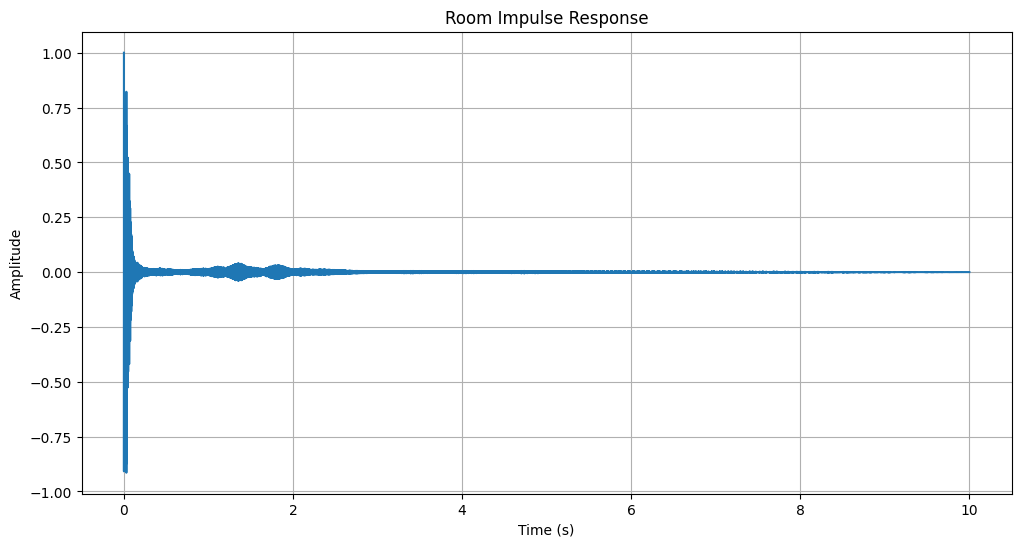

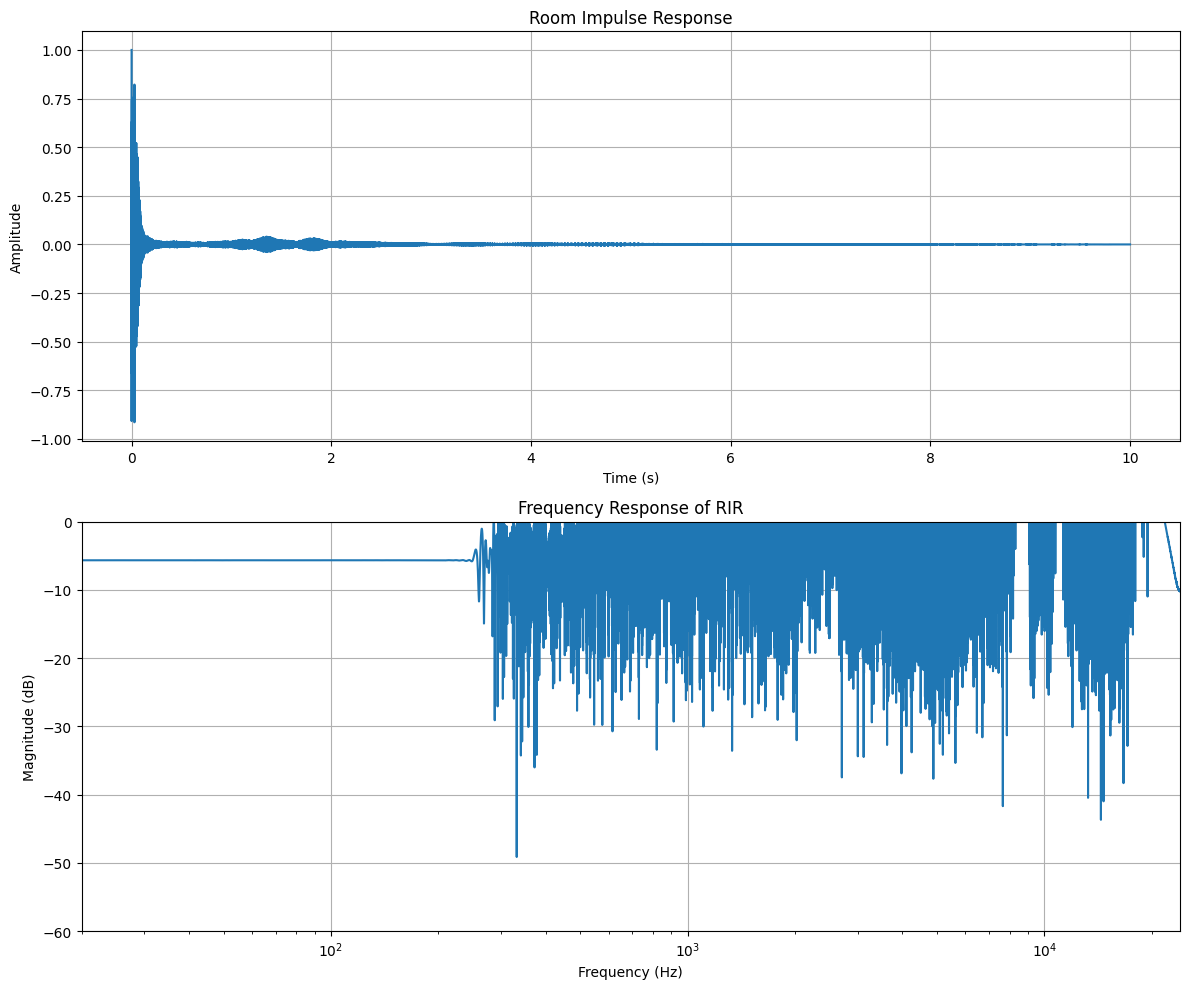

In [6]:

# Load recorded sweep
fs_rec, recorded_sweep = wavfile.read('KT_Unity_bf.wav')
rec_ch1 = recorded_sweep[:, 1] if recorded_sweep.ndim > 1 else recorded_sweep
rec_ch1 = rec_ch1.astype(float) / 32768.0

# Align and compute RIR
#rec_ch1, inverse_filter = align_signals(rec_ch1, inverse_filter)
rir = compute_rir(rec_ch1, inverse_filter, fs_rec)

# Save and plot RIR
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')
wavfile.write(output_path, fs_rec, np.int16(rir * 32767))
plot_signal(rir, fs_rec, 'Room Impulse Response')
plot_rir_and_spectrum(rir, fs_rec)